In [141]:
import glob
import struct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the file pattern is correct and should match all relevant files
files = glob.glob("data/data_info_101_*.bin")
# Sort files by name
files.sort()

# Read all files and accumulate bytes
my_bytes = b''
for file in files:
    with open(file, mode="rb") as f:
        my_bytes += f.read()

# Define column names and dtypes
columns_info = ["microstime",
                "pression", "temperature", "altitude", "pint", "pitot",
                "lat", "lon", "alt", "course", "speed", "hdop",
                "satellites", "gpstime", "apogee_detectee"]

dtypes_info = ['uint32',  # microstime
               'float32', 'float32', 'float32', 'float32', 'float32',  # sensor data
               'float64', 'float64', 'float64', 'float64', 'float64', 'float64',  # GPS data
               'uint32',  # satellites
               'uint32',  # gpstime
               'uint32_t']  # apogee_detectee

# Create the format string for struct.unpack
fmt = '<' + 'I'  # uint32_t for microstime
fmt += 'f' * 5  # 5 float32 for sensor data
fmt += 'd' * 6  # 6 float64 for GPS data
fmt += 'I' * 3  # 3 uint32_t for satellites and gpstime and apogee_detectee

# Calculate the size of one row in bytes
size = struct.calcsize(fmt)

# Keep the biggest multiple of size that is smaller than the number of bytes
num_complete_rows = len(my_bytes) // size 
my_bytes = my_bytes[:num_complete_rows * size]

# Convert bytes to pandas DataFrame
df_rows = []

for i in range(0, len(my_bytes), size):
    row_bytes = my_bytes[i:i + size]
    try:
        row = struct.unpack(fmt, row_bytes)
    except struct.error:
        row = [None] * len(columns_info)  # Handle any unpacking error by filling the row with None
    df_rows.append(row)

# Create DataFrame
df_info = pd.DataFrame(df_rows, columns=columns_info)
# drop the 4 first rows
df_info = df_info.iloc[4:]

print(df_info)


       microstime    pression  temperature    altitude      pint     pitot  \
4      1572977611  963.229980    46.200001  424.781342  5.655869  5.728233   
5      1572984277  963.159973    46.200001  425.388245  5.624303  5.728233   
6      1572990943  962.619995    45.900002  430.070648  5.624303  5.728233   
7      1572997609  962.150024    45.900002  434.147705  5.655869  5.728233   
8      1573004275  962.239990    45.950001  433.367096  5.592737  5.728233   
...           ...         ...          ...         ...       ...       ...   
12283  1654829425  934.750000    40.990002  674.682800  0.889420  5.728233   
12284  1654836091  934.929993    41.090000  673.084229  0.952552  5.728233   
12285  1654842757  934.909973    41.090000  673.262024  0.952552  5.728233   
12286  1654849423  934.679993    40.950001  675.304626  0.920986  5.728233   
12287  1654856089  934.210022    40.950001  679.480164  0.920986  5.728233   

             lat       lon    alt  course     speed  hdop  sate

In [142]:
# print ratio of times v is equal to its previous value for columns beginning with \"p\" and \"t\"\n",

ratio_p = len(df_info[df_info["pression"]==df_info["pression"].shift(1)])/len(df_info)
ratio_t = len(df_info[df_info["temperature"]==df_info["temperature"].shift(1)])/len(df_info)
print(ratio_p, ratio_t)

0.03337675024422013 0.5292250081406707


In [143]:
file_name_suffix = "full"
# file_name_suffix = "before_parachute"

In [144]:
t = df_info["microstime"]/10**6

decollage=1594.665 # selon les données
dec = 0 # selon ce qu'on veut dans les courbes
para = 12.821 # selon les données imus
t0 = decollage - 1 # début du plot
# fin du plot
if file_name_suffix == "full":
    tf = decollage+60 # fin du vol
else:
    tf = decollage+15 # un peu après le parachute
id_t0 = np.argmin(np.abs(t-t0))
id_tf = np.argmin(np.abs(t-tf))
print("id_t0",id_t0)
print("id_tf",id_tf)

id_t0 3103
id_tf 12254


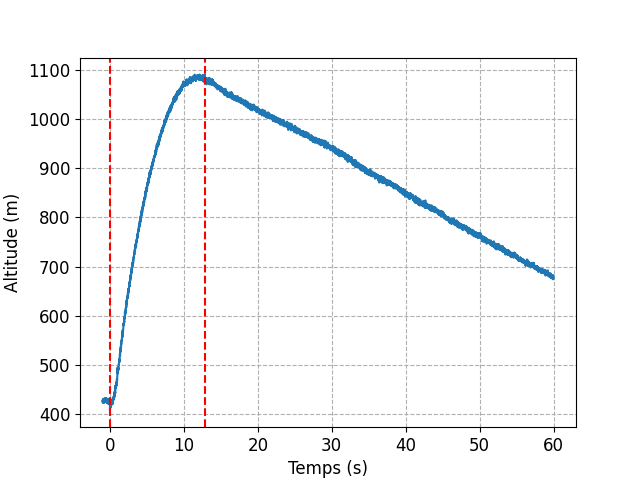

In [145]:
%matplotlib widget
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, df_info["altitude"][id_t0:id_tf])
# plt.plot(t[id_t0:id_tf]-decollage, df_info["alt"][id_t0:id_tf], linewidth=2)
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)', size=12)
plt.ylabel('Altitude (m)', size=12)
# plt.legend(['Baromètre', 'GPS'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"altitude_baro_{file_name_suffix}.png")
plt.show()

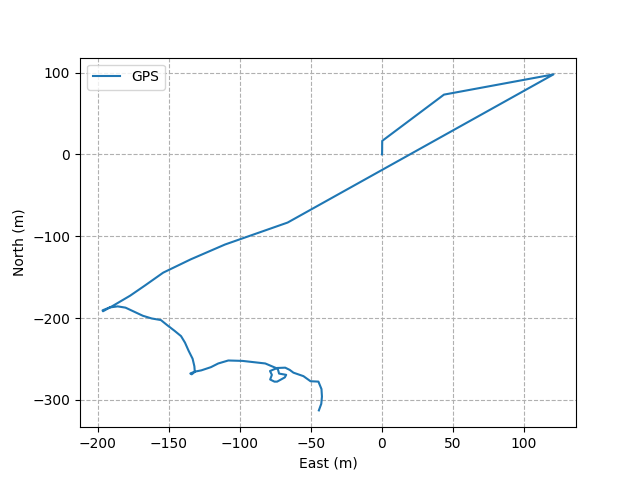

In [146]:
def lat_to_meter(lat):
    return lat * 40008000 / 360

def lon_to_meter(lon, lat):
    return lon * 40075000 * np.cos(lat) / 360

plt.figure()
plt.plot(lon_to_meter(df_info["lon"][id_t0:id_tf], df_info["lat"][id_t0:id_tf])-lon_to_meter(df_info["lon"].iloc[id_t0], df_info["lat"].iloc[id_t0]), lat_to_meter(df_info["lat"][id_t0:id_tf])-lat_to_meter(df_info["lat"].iloc[id_t0]))
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.legend(['GPS'])
plt.grid(linestyle='--')
plt.savefig(f"trajectoire_gps_{file_name_suffix}.png")
plt.show()

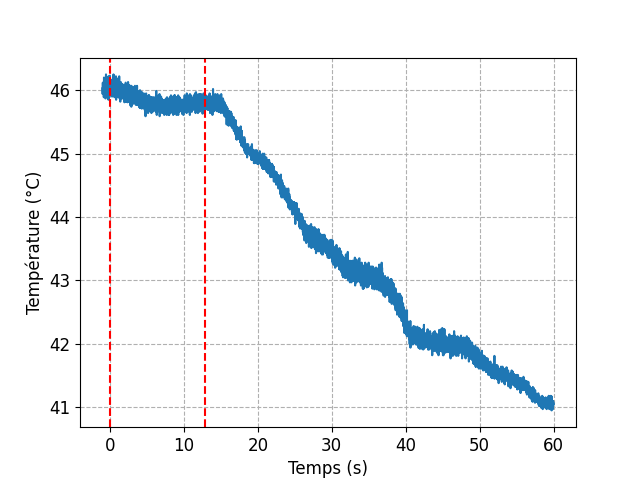

In [147]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, df_info["temperature"][id_t0:id_tf])
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)', size=12)
plt.ylabel('Température (°C)', size=12)
# plt.legend(['Temperature'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"temperature_baro_{file_name_suffix}.png")
plt.show()

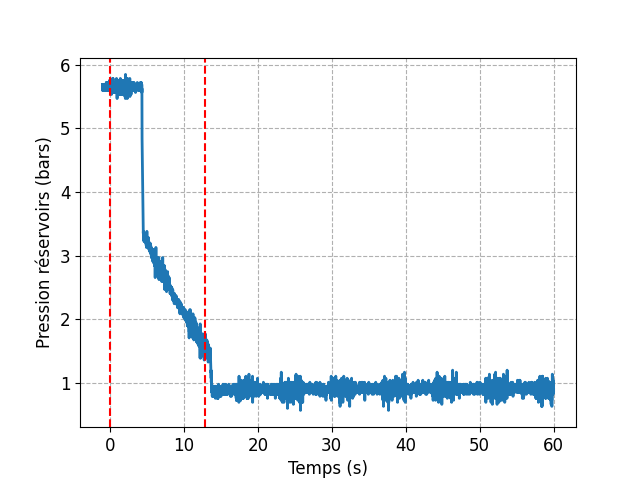

In [148]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, df_info["pint"][id_t0:id_tf],linewidth=2)
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)', size=12)
plt.ylabel('Pression réservoirs (bars)', size=12)
# plt.legend(['Pression réservoirs'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"pint_{file_name_suffix}.png")
plt.show()

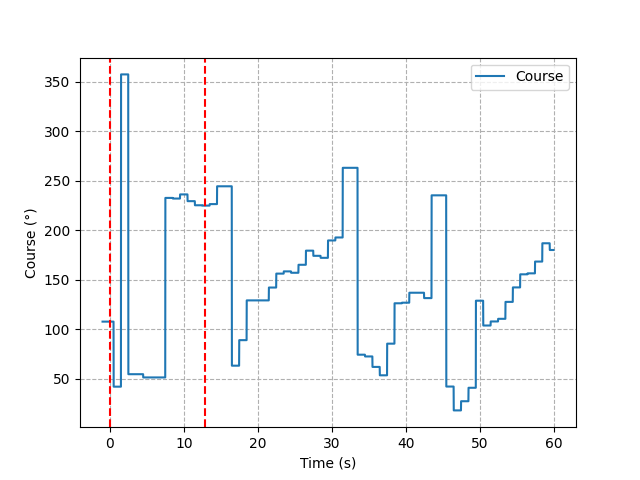

In [149]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, df_info["course"][id_t0:id_tf])
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Course (°)')
plt.legend(['Course'])
plt.grid(linestyle='--')
plt.savefig(f"course_{file_name_suffix}.png")
plt.show()

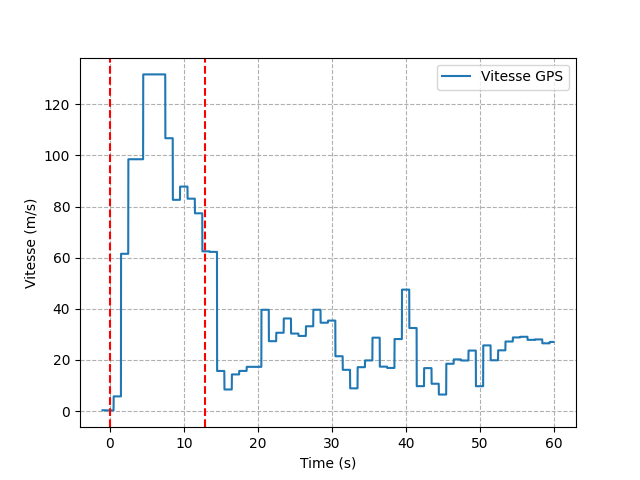

In [150]:
plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, df_info["speed"][id_t0:id_tf])
plt.axvline(x=dec, color='r', linestyle='--')
plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Vitesse (m/s)')
plt.legend(['Vitesse GPS'])
plt.grid(linestyle='--')
plt.savefig(f"speed_gps_{file_name_suffix}.png")
plt.show()

Apogée détectée à t = 10.74936700000012


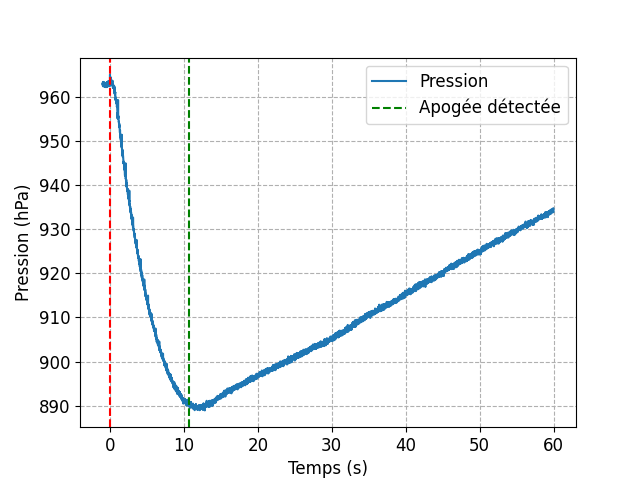

In [151]:
# Détection de l'apogée avec le même code que celui de la carte Info (pour voir si il aurait marché)

pressuresSize = 76

def PressureHasReachedMinimum(pressures, nextPosition):
    pressureAvgFirstHalf = 0
    pressureAvgSecondHalf = 0
    startPos = nextPosition
    endPos = (nextPosition + pressuresSize // 2) % pressuresSize

    i = startPos
    while i != endPos:
        pressureAvgFirstHalf += pressures[i]
        i = (i + 1) % pressuresSize
        
    pressureAvgFirstHalf /= pressuresSize / 2

    startPos = endPos
    endPos = nextPosition

    i= startPos
    while i != endPos:
        pressureAvgSecondHalf += pressures[i]
        i = (i + 1) % pressuresSize
    pressureAvgSecondHalf /= pressuresSize / 2

    return pressureAvgSecondHalf > pressureAvgFirstHalf

id_tdec = np.argmin(np.abs(t-(t0+1)))
pression_full = df_info["pression"][id_tdec:id_tf].values
pressures = np.zeros(pressuresSize)

nextPosition = 0

for i in range(len(pression_full)):
    pressures[nextPosition] = pression_full[i]
    nextPosition = (nextPosition + 1) % pressuresSize
    
    if i > pressuresSize and PressureHasReachedMinimum(pressures, nextPosition):
        print("Apogée détectée à t =", t[id_t0+i]-decollage)
        id_apogee = i
        break


plt.figure()
plt.plot(t[id_t0:id_tf]-decollage, df_info["pression"][id_t0:id_tf])
plt.axvline(x=t[id_t0+id_apogee]-decollage, color='g', linestyle='--')
plt.axvline(x=dec, color='r', linestyle='--')
# plt.axvline(x=para, color='r', linestyle='--')
plt.xlabel('Temps (s)',size=12)
plt.ylabel('Pression (hPa)',size=12)
plt.legend(['Pression', 'Apogée détectée'], fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.savefig(f"detection_apogee_{file_name_suffix}.png")